In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import MobileNetV2,Xception,EfficientNetB7,InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input,LSTM, ConvLSTM2D, MaxPooling3D, TimeDistributed, Dense, Flatten, Dropout, Bidirectional, MaxPooling2D, InputLayer, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from IPython.display import clear_output,Video

import os
import json
import cv2

#constants
IMG_SIZE = 112
FRAME_COUNT = 15

#  Loading Data 

In [2]:
scvd_train_dir = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train'
scvd_test_dir = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Test'
scvd_classes = ['Normal', 'Violence','Weaponized']

In [3]:
!apt-get install -y ffmpeg

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


# Convert video to frames

In [7]:
def load_video(path, nframes=FRAME_COUNT, size=(IMG_SIZE, IMG_SIZE)):
    frames = []
    cap = cv2.VideoCapture(path)

    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Get the total number of frames in the video
    skip_frames = max(1, (total_frames // nframes) -1)  # Ensure at least 1 frame is skipped

    for _ in range(nframes):
        ret, frame = cap.read()  # Read the current frame
        if not ret:
            break

        # Process the current frame (resize, convert, normalize)
        frame = cv2.resize(frame, size)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frame = frame / 255.0
        frames.append(frame)

        # Skip the specified number of frames
        for _ in range(skip_frames):
            cap.grab()  # Advance to the next frame without reading it

    cap.release() 
    return frames


def extract_frames(main_directory):
    features = []
    labels = []
    for c in scvd_classes:
        class_dir = os.path.join(main_directory,c)
        for i,video in enumerate(os.listdir(class_dir)): 
            if i < 200:
                if video.endswith(('.mp4', '.avi', '.mov')): 
                    video_path = os.path.join(class_dir, video)

                    # Load and process the video
                    frames = load_video(video_path)

                    if len(frames) == FRAME_COUNT:
                        features.append(frames)
                        labels.append(c)
    return np.asarray(features),np.array(labels)

In [8]:
normal = load_video('/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train/Normal/Normal001.avi')
violence = load_video('/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train/Violence/Violence001.avi')
weaponized = load_video('/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train/Weaponized/Weaponized001.avi')

***frame resize it to 112x112***

In [10]:
X_train,y_train = extract_frames(scvd_train_dir)
X_test,y_test = extract_frames(scvd_test_dir)

In [11]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((600, 15, 112, 112, 3), (600,), (477, 15, 112, 112, 3), (477,))

In [12]:
np.unique(y_train)

array(['Normal', 'Violence', 'Weaponized'], dtype='<U10')

#  weaponized+violence into one label "Violence" 

In [15]:
y_train = np.where(y_train == 'Weaponized','Violence',y_train)

y_test = np.where(y_test == 'Weaponized','Violence',y_test)

In [16]:
np.unique(y_train)

array(['Normal', 'Violence'], dtype='<U10')

# Converting labels to numeric format

In [20]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

#  Model 

MobileNetV2 as a base model with LSTM for video classification

In [21]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    TimeDistributed(base_model, input_shape=(15, 128, 128, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dropout(0.5)),
    TimeDistributed(BatchNormalization()),

    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## model training with early stopping and checkpointing

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    '/kaggle/working/cctvmodel.keras',  
    monitor='val_loss',
    save_best_only=True,  
    mode='min',  
)
history = model.fit(
    x=X_train,
    y= y_train,
    batch_size=4,
    validation_data=(X_test,y_test),
    callbacks=[early_stopping,checkpoint],
    epochs= 30,
)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 100s 266ms/step - accuracy: 0.5040 - loss: 0.9441 - val_accuracy: 0.6520 - val_loss: 0.5142
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.6403 - loss: 0.7163 - val_accuracy: 0.7925 - val_loss: 0.3900
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.7053 - loss: 0.6301 - val_accuracy: 0.9329 - val_loss: 0.2932
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.7511 - loss: 0.5205 - val_accuracy: 0.9434 - val_loss: 0.2432
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.7598 - loss: 0.5022 - val_accuracy: 0.9350 - val_loss: 0.2197
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.8102 - loss: 0.4424 - val_accuracy: 0.9811 - val_loss: 0.1022
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.8314 - loss: 0.4196 - val_accuracy: 0.9245 - val_loss: 0.1718
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.8337 - loss: 

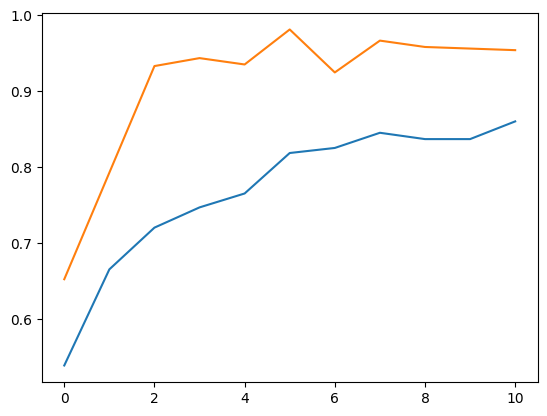

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [24]:
model.evaluate(X_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9852 - loss: 0.1009


[0.10215148329734802, 0.9811320900917053]

15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       169
           1       0.99      0.98      0.99       308

    accuracy                           0.98       477
   macro avg       0.98      0.98      0.98       477
weighted avg       0.98      0.98      0.98       477



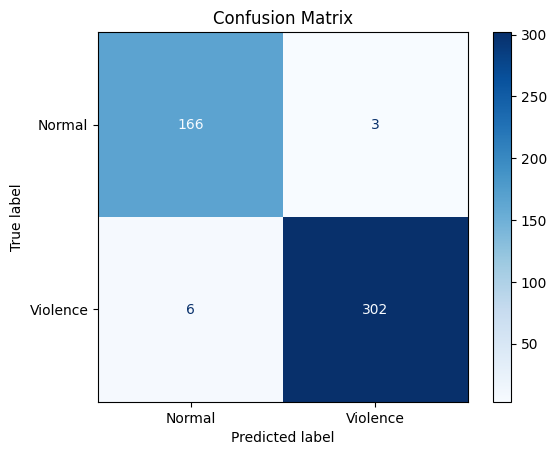

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violence'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()